[View in Colaboratory](https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/fastai_lesson_1.ipynb)

In [0]:
# script for installing fastai and required libraries
# note: using pytoch 0.3.0, may have to change later
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image
%matplotlib inline
!pip install fastai
!pip install pathlib
from fastai.imports import *

In [2]:
# check for CUDA
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

#print('Device:', torch.device('cuda:0'))


0.3.0.post4
True
Torch 0.3.0.post4 CUDA 8.0.61


In [3]:
# PIL workaround
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [4]:
# download data
!mkdir data && wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/


mkdir: cannot create directory ‘data’: File exists


In [0]:
# importing fast.ai libraries
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
PATH = "data/dogscats/"

In [0]:
sz=224

In [8]:
!ls {PATH}

models	sample	test1  train  valid


In [9]:
!ls {PATH}valid

cats  dogs


In [10]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

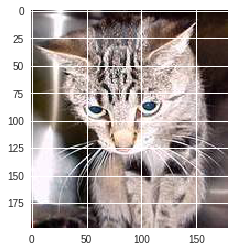

In [11]:
# plotting sample image
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [12]:
img.shape

(198, 179, 3)

In [13]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [0]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

# Process

1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1 (replace with STLR)
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting  (replace with STLR)
9. TTA

# Fine-tuning last layer 

In [15]:
# resnet34
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), bs=32)
model = ConvLearner.pretrained(arch, data, precompute=True)
model.fit(0.01, 3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 25309021.08it/s]


100%|██████████| 63/63 [00:15<00:00,  4.08it/s]


epoch      trn_loss   val_loss   accuracy   
    0      0.05697    0.028536   0.992     
    1      0.033897   0.033012   0.9915    
    2      0.050256   0.026198   0.991     



[array([0.0262]), 0.991]

# Learning rate schedule

In [19]:
# learning rate finder
lrf=model.lr_find()

 70%|██████▉   | 503/719 [00:08<00:03, 56.25it/s, loss=0.0853]


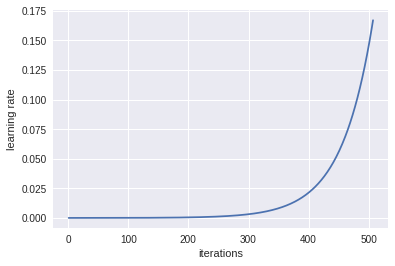

In [20]:
# plotting LR schedule
model.sched.plot_lr()

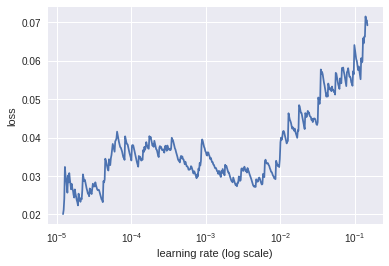

In [21]:
model.sched.plot()

use learning rate: 0.01

# Data Augmentation

In [0]:
# defining transformation function

tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
# augmented data

data_aug = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=64)

# new model
model = ConvLearner.pretrained(arch, data_aug, precompute=True)

In [0]:
# (optional) LR Scheduler again

In [27]:
# model fitting
model.fit(1e-2, 1) # train for 1 epoch with precomputed

epoch      trn_loss   val_loss   accuracy   
    0      0.052868   0.029489   0.989     



[array([0.02949]), 0.9890000004768371]

In [0]:
# set precompute to False
model.precompute=False

# cyclical learning rate (SGDR)

In [29]:
# train for 1 epoch with precompute false
model.fit(1e-2, 3, cycle_len=1) # cyclical learning rate SGDR for 1 cycle (3 epochs)

epoch      trn_loss   val_loss   accuracy   
    0      0.045202   0.028012   0.9885    
    1      0.0388     0.028069   0.9895    
    2      0.04168    0.027485   0.9895    



[array([0.02749]), 0.9895000004768372]

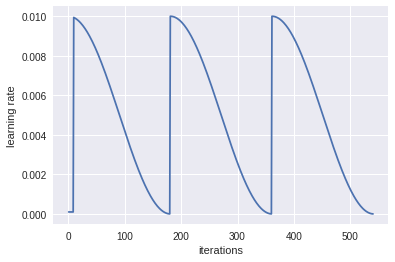

In [30]:
# plotting lr
model.sched.plot_lr()

# Slanted triangular LR



In [31]:
model.fit(1e-2, 1, cycle_len=10, use_clr=(32,10)) # cyclical learning rate Slanted triangular LR for 1 cycle (10 epochs)

epoch      trn_loss   val_loss   accuracy   
    0      0.042486   0.027281   0.989     
    1      0.0443     0.027197   0.989     
    2      0.039034   0.026187   0.9895    
    3      0.03291    0.026417   0.99      
    4      0.037716   0.026643   0.99      
    5      0.035932   0.02584    0.99      
    6      0.036222   0.02548    0.99      
    7      0.03164    0.025177   0.99      
    8      0.033216   0.024701   0.9905    
    9      0.032255   0.026239   0.99      



[array([0.02624]), 0.9900000004768371]

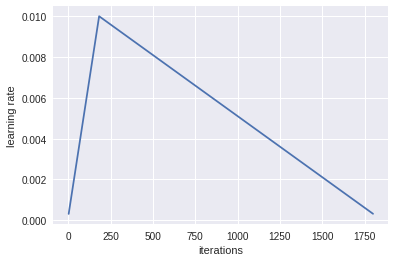

In [32]:
# plotting lr
model.sched.plot_lr()

# Unfreeze layers

In [0]:
model.unfreeze()

# Discriminative learning rate

In [0]:
lr=np.array([1e-4,1e-3,1e-2])

In [35]:
# fitting model with discriminative lr
model.fit(lr, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy   
    0      0.050213   0.032329   0.9875    
    1      0.042058   0.028111   0.99      
    2      0.031113   0.024269   0.9905    
    3      0.02927    0.022265   0.9915    
    4      0.021581   0.022475   0.992     
    5      0.021907   0.021597   0.992     
    6      0.018857   0.022623   0.991     
    7      0.02127    0.022423   0.992     
    8      0.016626   0.022359   0.9915    
    9      0.020643   0.022756   0.9915    



[array([0.02276]), 0.9915000004768372]

train until overfitting

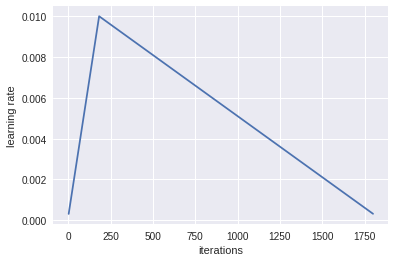

In [36]:
model.sched.plot_lr()

# Prediction and TTA

In [38]:
log_preds,y = model.TTA()
probs = np.mean(np.exp(log_preds),0)

In [41]:
accuracy_np(probs, y)

0.9955

# Model saving/loading

In [0]:
model.save('fastai_lesson_1')

In [0]:
model.load('fastai_lesson_1')